###  MicroGrad demo

In [3]:
import random

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

from micrograd.engine import Value
from micrograd.nn import MLP
from micrograd.optimizers import SGD

%matplotlib inline

In [4]:
rng = np.random.default_rng(1337)
random.seed(1337)

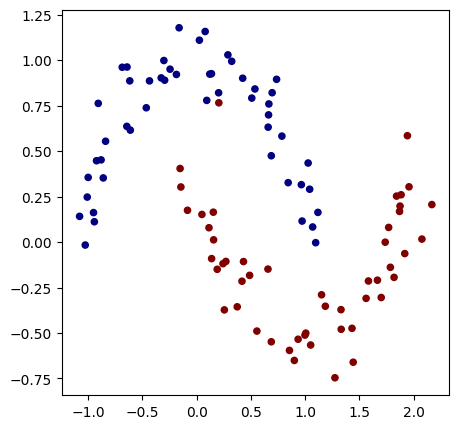

In [5]:
# make up a dataset

X, y = make_moons(n_samples=100, noise=0.1)

y = y * 2 - 1  # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="jet")

In [6]:
# initialize a model
model = MLP()
print(model)
print("number of parameters", len(model.parameters()))

MLP(l1=Linear(neurons=Neuron(in_features=2), Neuron(in_features=2), Neuron(in_features=2), Neuron(in_features=2), Neuron(in_features=2), Neuron(in_features=2), Neuron(in_features=2), Neuron(in_features=2), Neuron(in_features=2), Neuron(in_features=2), Neuron(in_features=2), Neuron(in_features=2), Neuron(in_features=2), Neuron(in_features=2), Neuron(in_features=2), Neuron(in_features=2)), l2=Linear(neurons=Neuron(in_features=16), Neuron(in_features=16), Neuron(in_features=16), Neuron(in_features=16), Neuron(in_features=16), Neuron(in_features=16), Neuron(in_features=16), Neuron(in_features=16), Neuron(in_features=16), Neuron(in_features=16), Neuron(in_features=16), Neuron(in_features=16), Neuron(in_features=16), Neuron(in_features=16), Neuron(in_features=16), Neuron(in_features=16)), l3=Linear(neurons=Neuron(in_features=16)))
number of parameters 337


In [7]:
# loss function
def loss(batch_size: int | None = None) -> tuple[Value, float]:
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = rng.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [[Value(x) for x in xrow] for xrow in Xb]

    # forward the model to get scores
    scores = [model(input)[0] for input in inputs]

    # svm "max-margin" loss
    losses = [
        (Value(1) + Value(-yi) * scorei).relu()
        for yi, scorei in zip(yb, scores, strict=True)
    ]
    data_loss = sum(losses, start=Value(0)) * (Value(1.0) / Value(len(losses)))
    # L2 regularization
    alpha = Value(1e-4)
    reg_loss = alpha * sum((p * p for p in model.parameters()), Value(0))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [
        (yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores, strict=True)
    ]
    return total_loss, sum(accuracy) / len(accuracy)


total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.9045749569505191, grad=0) 0.5


In [6]:
# optimization

sgd = SGD(model.parameters(), learning_rate=1)

for k in range(100):
    # forward
    total_loss, acc = loss()

    # backward
    sgd.zero_grad()
    total_loss.backward()

    # update (with sgd)
    sgd.step()
    sgd.learning_rate = 1.0 - 0.9 * k / 100

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 0.9125435269109486, accuracy 50.0%
step 1 loss 1.588209377168075, accuracy 78.0%
step 2 loss 0.6071000472137358, accuracy 83.0%
step 3 loss 0.5756408493769644, accuracy 85.0%
step 4 loss 0.2983590935605016, accuracy 87.0%
step 5 loss 0.2746776551517771, accuracy 88.0%
step 6 loss 0.26737383929221314, accuracy 91.0%
step 7 loss 0.2811275156167645, accuracy 88.0%
step 8 loss 0.29309712776047275, accuracy 91.0%
step 9 loss 0.3668610083615759, accuracy 86.0%
step 10 loss 0.2722713670234432, accuracy 90.0%
step 11 loss 0.24186217333576665, accuracy 90.0%
step 12 loss 0.2401337969098908, accuracy 92.0%
step 13 loss 0.2518271055993336, accuracy 90.0%
step 14 loss 0.2526357421787441, accuracy 91.0%
step 15 loss 0.3299845203746257, accuracy 87.0%
step 16 loss 0.232258443048468, accuracy 91.0%
step 17 loss 0.2093506856031809, accuracy 91.0%
step 18 loss 0.1896273163800046, accuracy 92.0%
step 19 loss 0.18883565675484312, accuracy 92.0%
step 20 loss 0.16806165549095267, accuracy 93.0%

(-1.5985541978086029, 2.151445802191397)

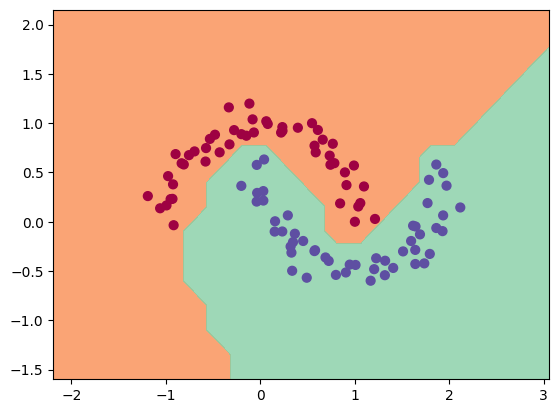

In [7]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = [model(input)[0] for input in inputs]
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)  # type: ignore
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)  # type: ignore
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
